# InterTwin Hydrological Appliction Workflow

In [7]:
#%%html
#<iframe src="https://excalidraw.com/#json=SFHh0RHH7VZ8G3kKOr7ay,Dvu8WqUyIb15UHiOgv_Llg" width="1600" height="800"></iframe>

![app_package_cwl.svg](app_package_cwl.svg)

# CWL 

## Application classes 

- **Worflow**: it defines the steps for producing an output, steps are usually made of ore or many commandLineTool (probably other classes as well..), how they are connected, etc.
- **CommandLineTool**: it's an executable that takes certain user defined arguments and produce certain outputs 
- Others

An app such as a commandLineTool can run in [docker] containers, pulled from a registry for example.

If the app other than taking user defined arguments, needs data or configuration files for running, they can be made available by mounting a volume inside the container, or in case of a STAC catalog through 
mapping the network interface between the host and the container.

The app assumes that the outputs are saved in the same location where the app is executed, the working directory. 

The app creates an output folder with randomly generated name and stsore the outputs there, if there are any outputs. 

It also produces a json that contains information about the location of the outputs.

## CWL runner [https://github.com/common-workflow-language/cwltool]

Basic functionality

`~$ cwltool app.cwl params.yaml` 

`cwltool` has many arguments..


In [2]:
!cwltool --help

usage: cwltool [-h] [--basedir BASEDIR] [--outdir OUTDIR] [--log-dir LOG_DIR]
               [--parallel]
               [--preserve-environment ENVVAR | --preserve-entire-environment]
               [--rm-container | --leave-container]
               [--cidfile-dir CIDFILE_DIR] [--cidfile-prefix CIDFILE_PREFIX]
               [--tmpdir-prefix TMPDIR_PREFIX]
               [--tmp-outdir-prefix TMP_OUTDIR_PREFIX | --cachedir CACHEDIR]
               [--rm-tmpdir | --leave-tmpdir]
               [--move-outputs | --leave-outputs | --copy-outputs]
               [--enable-pull | --disable-pull]
               [--rdf-serializer RDF_SERIALIZER] [--eval-timeout EVAL_TIMEOUT]
               [--provenance PROVENANCE] [--enable-user-provenance]
               [--disable-user-provenance] [--enable-host-provenance]
               [--disable-host-provenance] [--orcid ORCID]
               [--full-name CWL_FULL_NAME]
               [--print-rdf | --print-dot | --print-pre | --print-deps | --print-i


## HydroMT Application Package

![hydromt_using.jpg](hydromt_using.jpg)

![getting_started.png](getting_started.png)

### Gitlab repository

Dockerfile and source code for running the application packages.

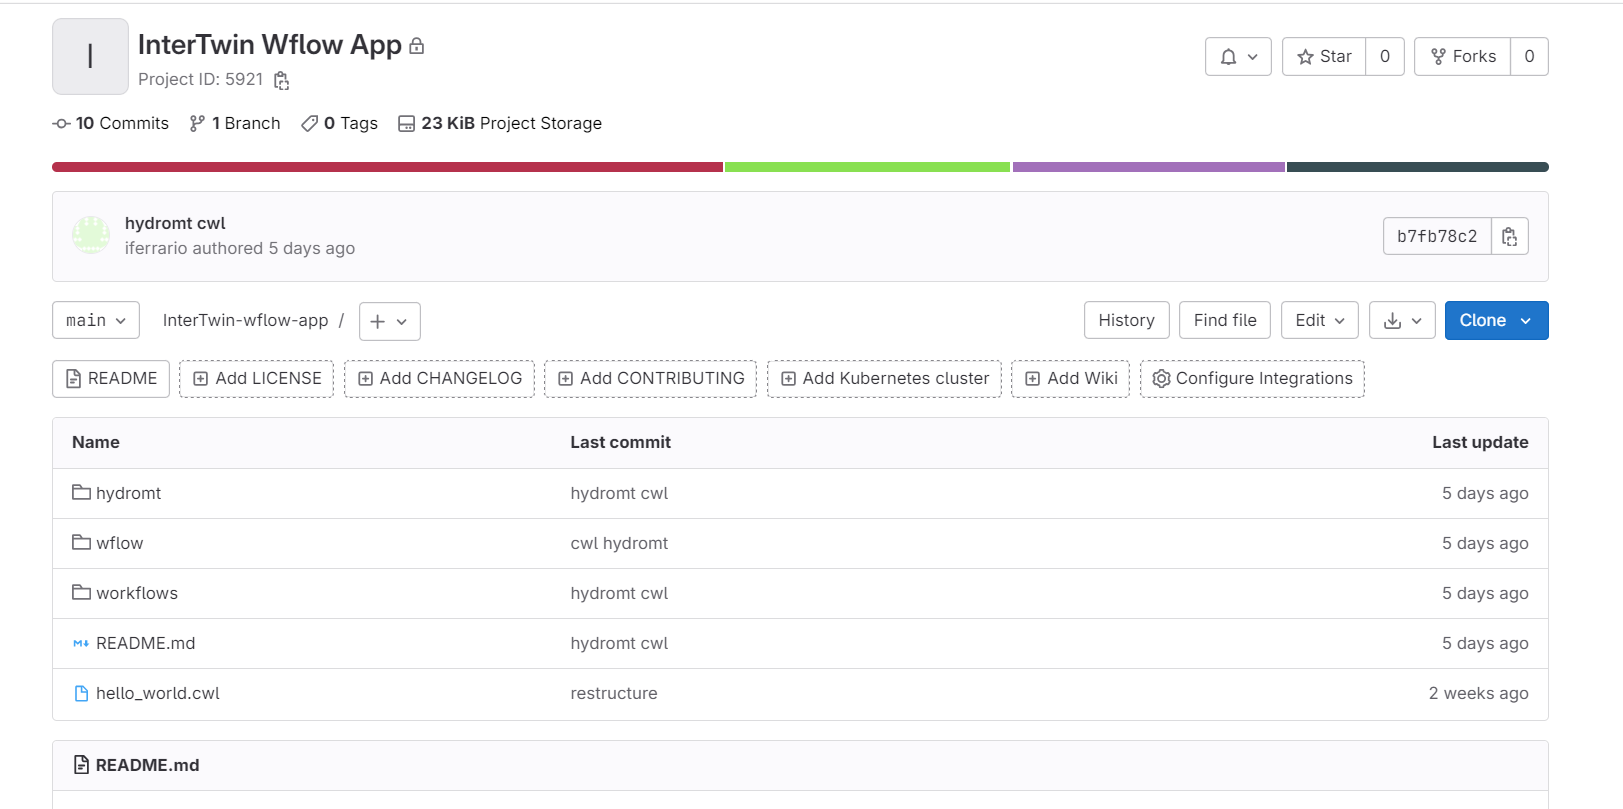


### Executable: build.sh

```bash
#!/bin/bash

## processing arguments
region=$1
setupconfig=$2
catalog=$3

## run application

hydromt build wflow model \
-r "$region" \
-d "$catalog" \
-i "$setupconfig" 

```

### Dockerfile
--- 

```docker
FROM ghcr.io/osgeo/gdal:ubuntu-small-3.8.1

RUN apt update
RUN apt -y install python3-pip

# python packages
COPY requirements.txt ./

RUN pip install --upgrade pip
RUN pip install --no-cache-dir -r requirements.txt

# directory where there are datasets referred by catalog.yaml
RUN mkdir /data 

COPY ./src/build.sh /usr/bin/build
RUN chmod +x /usr/bin/build
```

--- 

### CWL File

```cwl
#!/usr/bin/env cwl-runner

cwlVersion: v1.2
class: CommandLineTool
id: hydromt-build

requirements:
    DockerRequirement:
        dockerPull: gitlab.inf.unibz.it:4567/remsen/cdr/climax/meteo-data-pipeline:hydromt
        dockerOutputDirectory: /output
    InitialWorkDirRequirement:
        listing:
            - entry: $(inputs.volume_data)
              entryname: /data

baseCommand: build
arguments: []

inputs:
    region: # THIS COULD BE ALSO A VECTOR GIS FILE
        type: string
        inputBinding:
            position: 1
    setupconfig:
        type: File
        inputBinding:
            position: 2
    catalog: # THIS WILL BE A URL POINTING TO STAC OR A CATALOG.JSON
        type: File
        inputBinding:
            position: 3
    volume_data:
        type: Directory
        inputBinding:
            position: 4

outputs: # THIS SHOULD REFLECT THE OUTPUT FROM THE EXECUTABLE, AND IT CONTROLS THE JSON OUTPUT STRUCTURE
    output:
        outputBinding:
            glob: .
        type: Directory

```


### CWL input parameters
---
```yaml
region: "{'subbasin':[ 11.4750, 46.8717 ], 'strord':3}"
setupconfig:
  class: File
  path: wflow.ini
catalog: 
  class: File
  path: hydromt_data.yaml
volume_data: 
  class: Directory
  path: /mnt/CEPH_PROJECTS/InterTwin/Wflow/data
  
```

---

### RUN HYDROMT APP



In [15]:
!docker login gitlab.inf.unibz.it:4567 && cwltool -w output.json hydromt-build.cwl params.yaml

Authenticating with existing credentials...
WARNING! Your password will be stored unencrypted in /home/iferrario/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
INFO /home/iferrario/.local/miniforge/envs/hydromt_wflow/bin/cwltool 3.1.20231114134824
INFO Resolved 'hydromt-build.cwl' to 'file:///home/iferrario/dev/InterTwin-wflow-app/workflows/hydromt-build.cwl'
INFO [job hydromt-build] /tmp/ylz3qrzu$ docker \
    run \
    -i \
    --mount=type=bind,source=/tmp/ylz3qrzu,target=/output \
    --mount=type=bind,source=/tmp/73rh6ldb,target=/tmp \
    --mount=type=bind,source=/home/iferrario/dev/InterTwin-wflow-app/workflows/hydromt_data.yaml,target=/var/lib/cwl/stg55c42202-0b79-48ee-8284-44f32d9ead0a/hydromt_data.yaml,readonly \
    --mount=type=bind,source=/home/iferrario/dev/InterTwin-wflow-app/workflows/wflow.ini,target=/var/lib/cwl/stgc396d00e-2d4a-4c9a-9e9c-ee4a

### OUTPUT

In [17]:
!ls ./ylz3qrzu/model

forcings.nc  hydromt_data.yml  run_default  staticmaps.nc
hydromt.log  instate	       staticgeoms  wflow_sbm.toml


In [18]:
!cat output.json

{
    "output": {
        "location": "file:///home/iferrario/dev/InterTwin-wflow-app/workflows/ylz3qrzu",
        "basename": "ylz3qrzu",
        "class": "Directory",
        "listing": [
            {
                "class": "Directory",
                "location": "file:///home/iferrario/dev/InterTwin-wflow-app/workflows/ylz3qrzu/model",
                "basename": "model",
                "listing": [
                    {
                        "class": "Directory",
                        "location": "file:///home/iferrario/dev/InterTwin-wflow-app/workflows/ylz3qrzu/model/run_default",
                        "basename": "run_default",
                        "listing": [],
                        "path": "/home/iferrario/dev/InterTwin-wflow-app/workflows/ylz3qrzu/model/run_default"
                    },
                    {
                        "class": "File",
                        "location": "file:///home/iferrario/dev/InterTwin-wflow-app/workflows/ylz3qrzu/model/wf

In [5]:
#%%html
#<iframe src="https://excalidraw.com/#json=HEx_yK9lSJnb45W0p0bcO,x3hwjRh9fHMZTaac-B3gAg" width="1200" height="600"></iframe> 

![workflow_cwl.svg](workflow_cwl.svg)

## Next steps
  
- Hydromt reads STAC catalog instead of yaml file (therefore no need to pass any file, but just select the dataset from a STAC catalog)

- Setup config file: can a user upload the file? so that it is in the filesystem and hydromt app can find it    

- Develop Wflow application (some challenges to create an executable that runs julia wflow)

- Workflow to connect both applications

- Parsing output.json and loading to STAC catalog
- ... 

## WFLOW RUN